In [2]:
fimport codecs
import pandas as pd

def saveCsv(df):
    df.to_csv(('./dataset.csv'),sep=',', na_rep='NaN',encoding='utf=8')

positive = []; negative = [];
posneg = []

pos = codecs.open("./positive_words_self.txt", 'rb', encoding='UTF-8')
while True:
    line = pos.readline()
    line = line.replace('\n', '')
    positive.append(line)
    
    if not line:
        break 
pos.close() 

neg = codecs.open("./negative_words_self.txt", 'rb', encoding='UTF-8')
while True:
    line = neg.readline()
    line = line.replace('\n', '')
    negative.append(line)
    if not line: 
        break 
        
neg.close()
del positive[-1]; del negative[-1]

posneg = positive+negative


In [2]:
#-*- coding:utf-8 -*-

import os
import sys
import urllib.request
from urllib.parse import *
import requests
from bs4 import BeautifulSoup
#from kafka import KafkaProducer
import json
import re
import json
import datetime
from konlpy.tag import Okt

#with open('./config/config.json') as json_file:
#    config_data = json.load(json_file)

#kafka_ip = [config_data['kafka'] + ':9092']
#topic = 'naver.finance.board'

nlp = Okt()

dataset = []

j = 0

def remove_tag(content):
    cleanr = re.compile('<.*?>')
    result = re.sub(cleanr, '', content)
    return result


def get_bs_obj(url):
    result = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    bs_obj = BeautifulSoup(result.content, "html.parser")
    return bs_obj


class roomCrawler:
    main_url = 'https://finance.naver.com'

    def __init__(self, code='005930'):  # default code = 삼성전지
        self.room_url = self.main_url + '/item/board.nhn?code=' + code

    def detail_crawl(self, link):
        try:
            target_link = self.main_url + link
            bs = get_bs_obj(target_link)
            author_text = bs.find("span", class_="gray03").text
            ID, IP = author_text.split(" ")
            ID = ID[:-4]  # Erasing Masking

            og_date = bs.find("th", class_="gray03 p9 tah").text
            date_obj = datetime.datetime.strptime(og_date, '%Y.%m.%d %H:%M')
            date = date_obj.strftime('%Y-%m-%dT%H:%M:%S')

            title = bs.find("strong", class_="p15").text
            body = bs.find("div", id="body").text.replace("\r", " ")
            body = body.replace("\n", " ")
            total = title + ' ' + body
            post = total

        except Exception as err:
            post = None

        finally:
            return post

    def room_crawl(self, page=1):
        bs = get_bs_obj(self.room_url + '&page=' + str(page))
        lst = bs.find_all("td", class_="title")
        log_url = "http://127.0.0.1:8888/nfCrawlerResult"

        for i in range(len(lst) - 1, 0, -1):
            a = lst[i].find('a')
            link = a.get('href')
            post = self.detail_crawl(link)
            pos_cnt = 0
            neg_cnt = 0
            
            if post is None:
                continue
                
            for pn in range(len(posneg)):
                
                if pn < (len(positive)-1):
                    if post.find(posneg[pn]) != -1:
                        pos_cnt += 1
                if pn > (len(positive)-2):
                    if post.find(posneg[pn]) != -1:
                        neg_cnt += 1
                        
            total = pos_cnt + neg_cnt
            
            try:
                ratio = pos_cnt / total
            except Exception as err:
                ratio = 0
            
            if ratio >= 0.6:
                pos_value = 1
            elif ratio <= 0.4:
                pos_value = -1
            else:
                pos_value = 0
            
            dataset.append({
                "label": pos_value,
                "content":post
                           })

    def run(self):
        for i in range(1, 6):
            self.room_crawl(i)

if __name__ == "__main__":
    crawler = roomCrawler('005930')
    crawler.run()
    
df = pd.DataFrame(dataset)

In [6]:
for item in dataset:
    print(item)

{'label': -1, 'content': '삼성전자는 환율보고 거래하세요'}
{'label': -1, 'content': '김현미 허는짓거리봐라ㅡ미안한지도모르고ㅡㅡ이런아사리판에서 누구돈따무그러들어왔냐?  지난 19일 경기도 김포시와 대구시 수성구, 부산시 해운대·수영·동래·연제·남구를 조정대상지역으로 지정했다. 접경 지역인 김포 대곶면, 월곶면, 통진읍, 하성면만 예외로 뒀을 뿐, 나머지 규제는 모두 구 단위로 지정했다. 국토부는 현재까지 48개 투기과열지구와 75개 조정대상지역을 지정했는데, 대부분 시·군·구 단위로 묶은 것이다.     단적인 예로 ㅡㅡㅡ , 대구 ㅡㅡ수성구 시지동 ‘노변다숲’ 전용면적 59.73㎡(3층)ㅡ 지난 1일 1억8700만원에 거래됐다.  앞서 2017년 7월 같은 면적(4층)이 ㅡ1억9000만원에 거래됐던 것과 비교하면 3년 동안 가격이 오히려 소폭 하락한 셈이다.  반면ㅡㅡ  수성구의ㅡ 대표적인 고가 아파트인  ★★★범어동 ‘두산위브더제니스’ 전용면적 129.02㎡(35층)ㅡㅡ 지난달 21일 17억5000만원에 거래되며 신고가를 기록했다.  2017년 7월 21일에 동일 면적(34층)이 10억9500만원으로 거래된 것과 비교하면 ㅡ ♥♥3년 간 가격 상승률이 60%에 이른다.   부산도 ㅡ동별 편차가 높게 나타났다 . 부산 ㅡㅡ수영구 전체의 최근 한 달간 단위 공급면적(㎡) 당 아파트값 상승률은 2.23%로 조사됐는데  이는 구 전체 상승률을 주도한 수영동(13.27%)의 영향이 컸다. 같은 기간 광안동, 망미동, 민락동 등 나머지 동의 상승률은 0~1%대에 그쳤다.   "특정 신축 고가 단지 위주로 거래량이 폭증하고 가격이 상승하면서 구 단위 아파트값 상승률이 높게 나타났을 뿐ㅡ, 구축 중·저가 아파트의 시세는 상대적으로 안정적이었다"면서 "광범위한 조정대상지역 지정으로 실수요자의 피해가 우려된다"고 말했다.  지난 22일 ㅡㅡ광주광역시ㅡ  국토교통부에 투기과열지구 지정 단위를 시·자치구에서 동(洞) 단위로 낮춰달라고 건의

In [62]:
import csv

dataset = []
contents = []
f = open('output.csv', 'r', encoding='utf-8')
rdf = csv.reader(f)
for line in rdf:
    contents.append(line[0]+' '+line[1])
f.close()

del contents[0]

for post in contents:
    pos_cnt = 0
    neg_cnt = 0

    for pn in range(len(posneg)):
        index = -1
        score = 0
        while True:
            index = post.find(posneg[pn], index + 1)
            if index == -1:
                break
            else:
                score += 1

        if pn < (len(positive)-1):
                pos_cnt += score
        else:
                neg_cnt += score

    total = pos_cnt + neg_cnt
    try:
        ratio = pos_cnt / total
    except Exception as err:
        ratio = 0

    if ratio >= 0.6:
        pos_value = 1
    elif ratio <= 0.4:
        pos_value = -1
    else:
        pos_value = 0

    dataset.append({
        "label": pos_value,
        "content":post
                   })
    
df = pd.DataFrame(dataset)
saveCsv(df)

In [63]:
print(dataset)

[{'label': -1, 'content': '예금 8천있는데 다깨서 삼전살까요? 진지하게 고민중입니다. 삼전 400주있긴한데 여기서 추매해야할거같아서요'}, {'label': 1, 'content': '개미들 오늘도 팔고있네 수익이지만 더간다 더 올라간다 '}, {'label': -1, 'content': '완전 난리네 65500언에 들어오는 사람도 있네  그래도 100언 남기는 남네 ㅎㄷㄷ  근데  이때까지 머하다가 지금 들어오는거임 ?'}, {'label': -1, 'content': '삼성전자 성격알지??     한번  시도걸면   뒤도안돌아본다는거 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ'}, {'label': 1, 'content': '모간이 무섭네 모간이 매수할땐 쭉오르다 매수 멈추니 안오르네 ㅋㅋㅋㅋ'}, {'label': -1, 'content': '상속세와 불법승계 재판 12월 초 안에 7만원대 안착하면 상속세 1조 이상 늘어날꺼 같다  예전 삼성물산이랑 제일모직 합병때에는 삼성물산이 아파트 호황기에 거의 모든 수주를 포기해버리고 주가 폭락시켰거든  하지만 지금은 얘기가 다르다 불법승계 재판받고 있으면서 삼성전자 실적 마사지 못한다  개미들아 최소한 상속세는  신경 안쓰고 사도 된다'}, {'label': 1, 'content': '개인들전부털구  기관과외국인힘으로 코스피올리자 개인들전부버립시다 개인들 매년매수액30조원 잇든말든 .. 이번은 개인30조원매수없어도 ...외국인들매수200조원으로 삼성전자하이닉스등 대기업주매수로 코스피 3000확실시찍자.. 트럼프수혜주 중소기업주는어전 디제라 서서히 물러나라 잡주들아........... 삼성,하이닉스,엘지와 외인으로 코스피3000가자'}, {'label': -1, 'content': '대한민국이 너무나 살기 좋다는 이유로 대한민국을 지켜야한다  문재인은 또 당선되서 독재로 가야한다  대한민국을 지켜야하기때문에  여자들의 판단머리가 맞지, 남자들은

In [64]:
f = open('./dataset.csv', 'r', encoding='utf-8')
rdf = csv.reader(f)
for line in rdf:
    print(line)
f.close()

['', 'label', 'content']
['0', '-1', '예금 8천있는데 다깨서 삼전살까요? 진지하게 고민중입니다. 삼전 400주있긴한데 여기서 추매해야할거같아서요']
['1', '1', '개미들 오늘도 팔고있네 수익이지만 더간다 더 올라간다 ']
['2', '-1', '완전 난리네 65500언에 들어오는 사람도 있네  그래도 100언 남기는 남네 ㅎㄷㄷ  근데  이때까지 머하다가 지금 들어오는거임 ?']
['3', '-1', '삼성전자 성격알지??     한번  시도걸면   뒤도안돌아본다는거 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ']
['4', '1', '모간이 무섭네 모간이 매수할땐 쭉오르다 매수 멈추니 안오르네 ㅋㅋㅋㅋ']
['5', '-1', '상속세와 불법승계 재판 12월 초 안에 7만원대 안착하면 상속세 1조 이상 늘어날꺼 같다  예전 삼성물산이랑 제일모직 합병때에는 삼성물산이 아파트 호황기에 거의 모든 수주를 포기해버리고 주가 폭락시켰거든  하지만 지금은 얘기가 다르다 불법승계 재판받고 있으면서 삼성전자 실적 마사지 못한다  개미들아 최소한 상속세는  신경 안쓰고 사도 된다']
['6', '1', '개인들전부털구  기관과외국인힘으로 코스피올리자 개인들전부버립시다 개인들 매년매수액30조원 잇든말든 .. 이번은 개인30조원매수없어도 ...외국인들매수200조원으로 삼성전자하이닉스등 대기업주매수로 코스피 3000확실시찍자.. 트럼프수혜주 중소기업주는어전 디제라 서서히 물러나라 잡주들아........... 삼성,하이닉스,엘지와 외인으로 코스피3000가자']
['7', '-1', '대한민국이 너무나 살기 좋다는 이유로 대한민국을 지켜야한다  문재인은 또 당선되서 독재로 가야한다  대한민국을 지켜야하기때문에  여자들의 판단머리가 맞지, 남자들은 안맞아요']
['8', '1', '자율주행차 1대에 반도체 2000개필요… 또 다른 블루오션 ㅋ 대박 ㅊㅊ   ㅋㅋ']
['9', '1', '개인들은 아직

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
dataset = pd.read_csv('./dataset.csv')

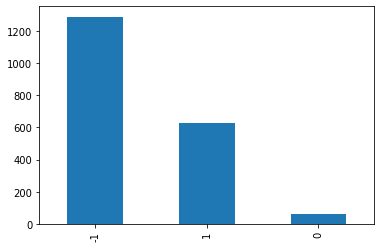

In [66]:
dataset['label'].value_counts().plot(kind='bar')

In [67]:
train_data = dataset[:1700]
test_data = dataset[1700:]
stopwords = ['.',',','','의','가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를','으로', '자', '에', '와', '한', '하다']

In [72]:
import konlpy
import re
from konlpy.tag import Okt
from keras.preprocessing.text import Tokenizer

hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')

X_train = []
for sentence in train_data['content']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    token_X = []
    for word in temp_X:
        temp = hangul.sub('',word)
        if temp == '' or temp in stopwords:
            continue
        token_X.append(temp)
    X_train.append(token_X)
    
X_test = []
for sentence in test_data['content']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    token_X = []
    for word in temp_X:
        temp = hangul.sub('',word)
        if temp == '' or temp in stopwords:
            continue
        token_X.append(temp)
    X_test.append(token_X)

print(X_test)

[['상속세', '내야', '놔눠', '서', '내다', '세금', '만', '조', '이상', '내야', '뭐', '팔', '아', '내야', '하나', '집팔', '아', '내다', '부자', '머리', '좋다'], ['이제', '부터', '말', '아', '올리다'], ['외국', '놈', '매수', '때', '무조건', '매수', '만', '원', '내', '무조건', '사라', '고', '개미', '다', '팔', '아', '먹다', '지금', '늦다', '들어오다', '폭락', '내', '던지다', 'ㅋ', '삼성', '자기', '자리', '돌아오다', '빠르다', '일주일', '늦다', '달이', '내다', '크다', '악재', '만', '없다', 'ㅋ'], ['삭제', '되다', '게시', '물의', '답글', '축하', '드리다', '개', '주접', '떨다'], ['거', '아무래도', '풀', '매수', '땡기다', '싶다', '자꾸', '지', '지선', '지지', '버리다', '제대로', '내려가다', '생각', '없다', '느낌'], ['개관', '이라고', '개욕', '개미', '파네', 'ㅋㅋㅋ', 'ㅋㅋㅋ'], ['이틀', '조정', '하고', '원', '까지', 'ㄱ', 'ㄱ', '나무', '보지', '말고', '숲', '을', '보다'], ['원', '엔도', '보다', '물론', '삼전', '일본', '경쟁자', '없다', '무관', '엔', '원화', '원', '떨어지다', '동안', '거의', '안', '움직임', '엔', '엔', '떨어지다'], ['외', '인들', '왜', '이르다', '엄청', '사대', '네'], ['원', '원', '판', '사람', '처럼', '안되다', '들다', 'ㅇㅓ', '이번', '주', '팔다', '원', '이상', '보다'], ['전문가', '년내', '간다', '오늘이', '고', '점', '이다', '간다'], ['분', '기', '배당', '기준', '일', '및', '지급',

In [73]:
max_words = 35000
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [75]:
print(len(X_train))

1700


리뷰의 최대 길이 : 2273
리뷰의 평균 길이 : 35.54117647058823


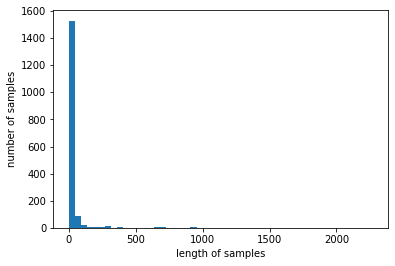

전체 샘플 중 길이가 200 이하인 샘플의 비율: 96.76470588235294


In [76]:
import numpy as np

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if len(s) <= max_len:
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

y_train = []; y_test = []
for i in range(len(train_data['label'])):
    if train_data['label'].iloc[i] == 1:
        y_train.append([0,0,1])
    elif train_data['label'].iloc[i] == 0:
        y_train.append([0,1,0])
    elif train_data['label'].iloc[i] == -1:
        y_train.append([1,0,0])

for i in range(len(test_data['label'])):
    if test_data['label'].iloc[i] == 1:
        y_test.append([0,0,1])
    elif test_data['label'].iloc[i] == 0:
        y_test.append([0,1,0])
    elif test_data['label'].iloc[i] == -1:
        y_test.append([1,0,0])
        
y_train = np.array(y_train)
y_test = np.array(y_test)

print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

below_threshold_len(200, X_train)

In [77]:
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

max_len = 200 # 전체 데이터의 길이를 20로 맞춘다 
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

model = Sequential()
model.add(Embedding(max_words, 100))
model.add(LSTM(128))
model.add(Dense(3, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=20,callbacks=[es,mc],batch_size=10, validation_split=0.1)

C:\Users\HAYOUNG LEE\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1530 samples, validate on 170 samples
Epoch 1/20
1530/1530 [==============================] - 33s 22ms/step - loss: 0.7485 - acc: 0.6490 - val_loss: 0.6215 - val_acc: 0.7294: 35s - loss: 1.0705 - acc: 0.48 - ETA: 33s -  - ETA: 28s - lo - ETA: 25s - loss: 0.8747 - acc: 0.58 - ETA: 25 - ETA: 21s -  - ETA: 14s - loss: 0.7908 - a - ETA: 13s - loss: 0.7925 - acc: 0.61 - ETA: 13 - ETA: 10s - loss: 0.7828 - - ETA: 8s - loss: 0.7815 - acc:  - ETA: 7s - loss:  - ETA: 3s - loss: 0.7

Epoch 00001: val_acc improved from -inf to 0.72941, saving model to best_model.h5
Epoch 2/20
1530/1530 [==============================] - 35s 23ms/step - loss: 0.4656 - acc: 0.8281 - val_loss: 0.4901 - val_acc: 0.8176

Epoch 00002: val_acc improved from 0.72941 to 0.81765, saving model to best_model.h5
Epoch 3/20
1530/1530 [==============================] - 36s 23ms/step - loss: 0.3075 - acc: 0.8961 - val_loss: 0.4700 - val_acc: 0.852971 - acc: 0.90 - ETA: 12s - loss: 0.3030 - acc: 0. - ETA:  - ET

Epoch 00

In [78]:
print(model.evaluate(X_test, y_test)[1]*100)

276/276 [==============================] - 0s 935us/step
77.89855003356934
